In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from glob import glob
import pymannkendall as mk
import seaborn as sn
import statsmodels.api as sm
from collections import defaultdict


In [2]:
df_anom = pd.read_csv("data/pos/filled_tmean_anomaly_groups_kmeans.csv", index_col=0)
df_clim = pd.read_csv("data/pos/filled_tmean_clim_groups_kmeans.csv", index_col=0)
df_tmean = pd.read_csv("data/pos/filled_tmean_groups_kmeans.csv", index_col=0)
citys = pd.read_csv("data/statics/cidades.csv", index_col=2).drop(columns=['Unnamed: 0'])

In [3]:
def is_consecutive(days):
    if days>=1 and days<=3:
        return True
    else:
        return None

def test_mann_kendall(dados, title):
    resultado = mk.original_test(dados, alpha=0.05)
    # print(title)
    # print(f"Tendência: {resultado.trend}")
    # print(f"Slope: {float(resultado.slope)}")
    # print(f"{title}: Significância (p <= 0.05): {'Rejeita H0 (há tendência)' if resultado.p <= 0.05 else 'Não rejeita H0 (sem tendência)'}")
    # print('--'*5)
    values = f"Coef.: {round(float(resultado.slope),1)}.\nInterc.: {round(float(resultado.intercept),1)}.\np-value: {round(float(resultado.p),3)}"
    if resultado.p <= 0.05:
        color, msg = 'red', f'{title}:\nRejeita H0 (há tendência).\nCoef.: {round(float(resultado.slope),1)}.\nInterc.: {round(float(resultado.intercept),1)}.\np-value: {round(float(resultado.p),3)}'
    else:
        color, msg = 'black', f'{title}:\nNão rejeita H0 (sem tendência).\nCoef.: {round(float(resultado.slope),1)}.\nInterc.: {round(float(resultado.intercept),1)}.\np-value: {round(float(resultado.p),3)}'
    return resultado, msg

In [4]:
def calc_ehi_sig(last3days, p95):
    return last3days.mean() - p95
    
def calc_ehi_accl(last3days, last30days):
    return last3days.mean() - last30days.mean()
    
def ehf(df, percentil):
    p = df.quantile(percentil)
    data = list()
    for i in range(34, len(df)):

        time = df.index[i-1]
        temperature_mean = df.iloc[i-1]
        
        last3days = df.iloc[i-3:i]
        last30days = df.iloc[i-34:i-3]
        
        ehi_sig = calc_ehi_sig(last3days, p)
        ehi_accl = calc_ehi_accl(last3days, last30days) 
        
        EHF = max(0, ehi_sig) * max(1, ehi_accl) 
    
        data.append({
                'time':time, 'temperature_mean':temperature_mean, 'ehfsig':ehi_sig, 'ehfacl':ehi_accl, 'EHF':EHF})
        
    df_ehf = pd.DataFrame(data)
    df_ehf = df_ehf[df_ehf['EHF']>0]
    df_ehf.index = pd.to_datetime(df_ehf.time)
    df_ehf['severity'] = df_ehf[df_ehf.EHF>0]['EHF'] / df_ehf[df_ehf.EHF>0]['EHF'].quantile(0.85)
    return df_ehf

In [5]:
def process_hw(hw):
    init_at = hw.index[0]
    end_at = hw.index[-1]
    pico = hw.severity.max()
    tamanho = len(hw.index)
    carga = hw.severity.sum()
    mean = carga / tamanho
    return pd.DataFrame({'mean': [mean], 'init_at':[init_at], 'end_at':[end_at], 'pico':[pico], 'carga':[carga], 'tamanho':[tamanho], 'mean':[mean]}, index=[init_at])

def extract(df_tmean, grupo):
    df_ehf = ehf(df_tmean[grupo], 0.95)
    df_ehf.index = pd.to_datetime(df_ehf.index)
    df_ehf = df_ehf[df_ehf['EHF']>0]
    
    df_ehf['current'] = pd.to_datetime(df_ehf['time'].values)
    df_ehf['before'] = pd.to_datetime(df_ehf['time'].shift(1).values)
    df_ehf['days'] =  [(d).total_seconds() / 60 / 60 / 24 for d in (df_ehf['current'] - df_ehf['before'])]
    
    hws = list()
    for i in range(len(df_ehf)):
        
        days = df_ehf.days.iloc[i]
        times = list()
        
        if days>1:
            c = i + 1
            times.append(df_ehf.time.iloc[i])
            if c == len(df_ehf):
                break
            while float(df_ehf.days.iloc[c]) == 1:
                time = df_ehf.time.iloc[c]
                times.append(time)
                c+=1
                if c == len(df_ehf):
                    break
            
            hws.append(df_ehf[times[0]:times[-1]])
    
    df_hws = list()
    for hw in hws:
        df_hws.append(process_hw(hw))
    
    df_hws = pd.concat(df_hws)
    return df_ehf, df_hws

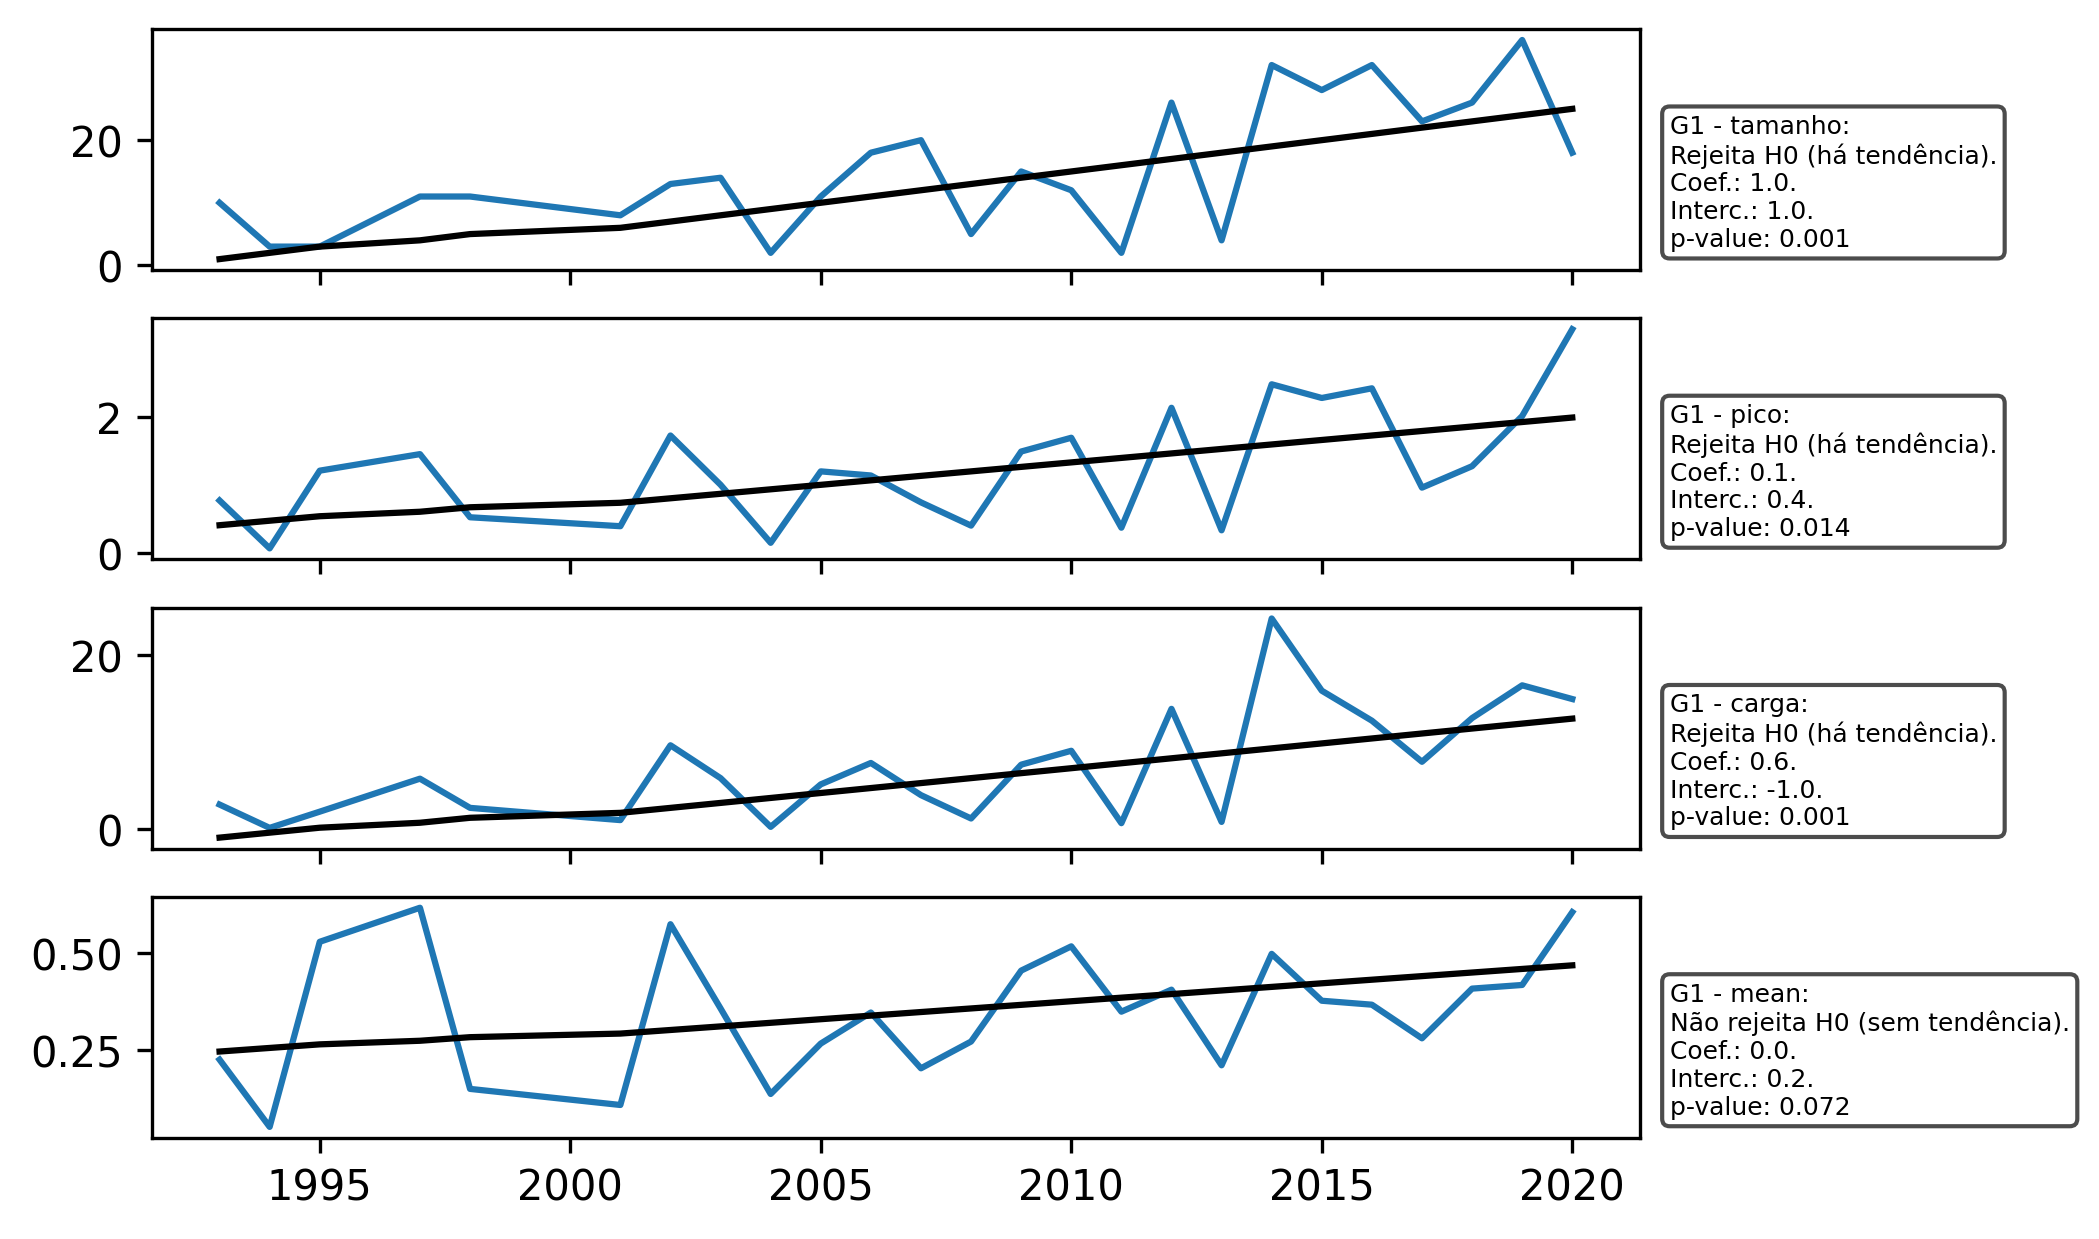

In [6]:
group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}

gstr = 'G1'

df_ehf, df_hws = extract(df_tmean, grupo=gstr)
tamanho = df_hws.groupby(df_hws.index.year)['tamanho'].sum()
pico = df_hws.groupby(df_hws.index.year)['pico'].max()
carga = df_hws.groupby(df_hws.index.year)['carga'].sum()
mean = df_hws.groupby(df_hws.index.year)['mean'].mean()

fig, ax = plt.subplots(4,1, dpi=300, sharex=True)

msgs = list()

tamanho.plot(ax=ax[0])
resultado, msg = test_mann_kendall(tamanho, f'{gstr} - tamanho')
trend_line = np.arange(len(tamanho)) * resultado.slope + resultado.intercept
ax[0].plot(tamanho.index, trend_line, color='black')

msgs.append(msg)


x, y = 1.02, 0.1
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

msgs = list()

pico.plot(ax=ax[1])
resultado, msg = test_mann_kendall(pico, f'{gstr} - pico')
trend_line = np.arange(len(pico)) * resultado.slope + resultado.intercept
ax[1].plot(pico.index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.1
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

msgs = list()
carga.plot(ax=ax[2])
resultado, msg = test_mann_kendall(carga, f'{gstr} - carga')
trend_line = np.arange(len(carga)) * resultado.slope + resultado.intercept
ax[2].plot(carga.index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.1
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

msgs = list()
mean.plot(ax=ax[3])
resultado, msg = test_mann_kendall(mean, f'{gstr} - mean')
trend_line = np.arange(len(mean)) * resultado.slope + resultado.intercept
ax[3].plot(mean.index, trend_line, color='black')


msgs.append(msg)


x, y = 1.02, 0.1
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

plt.show()

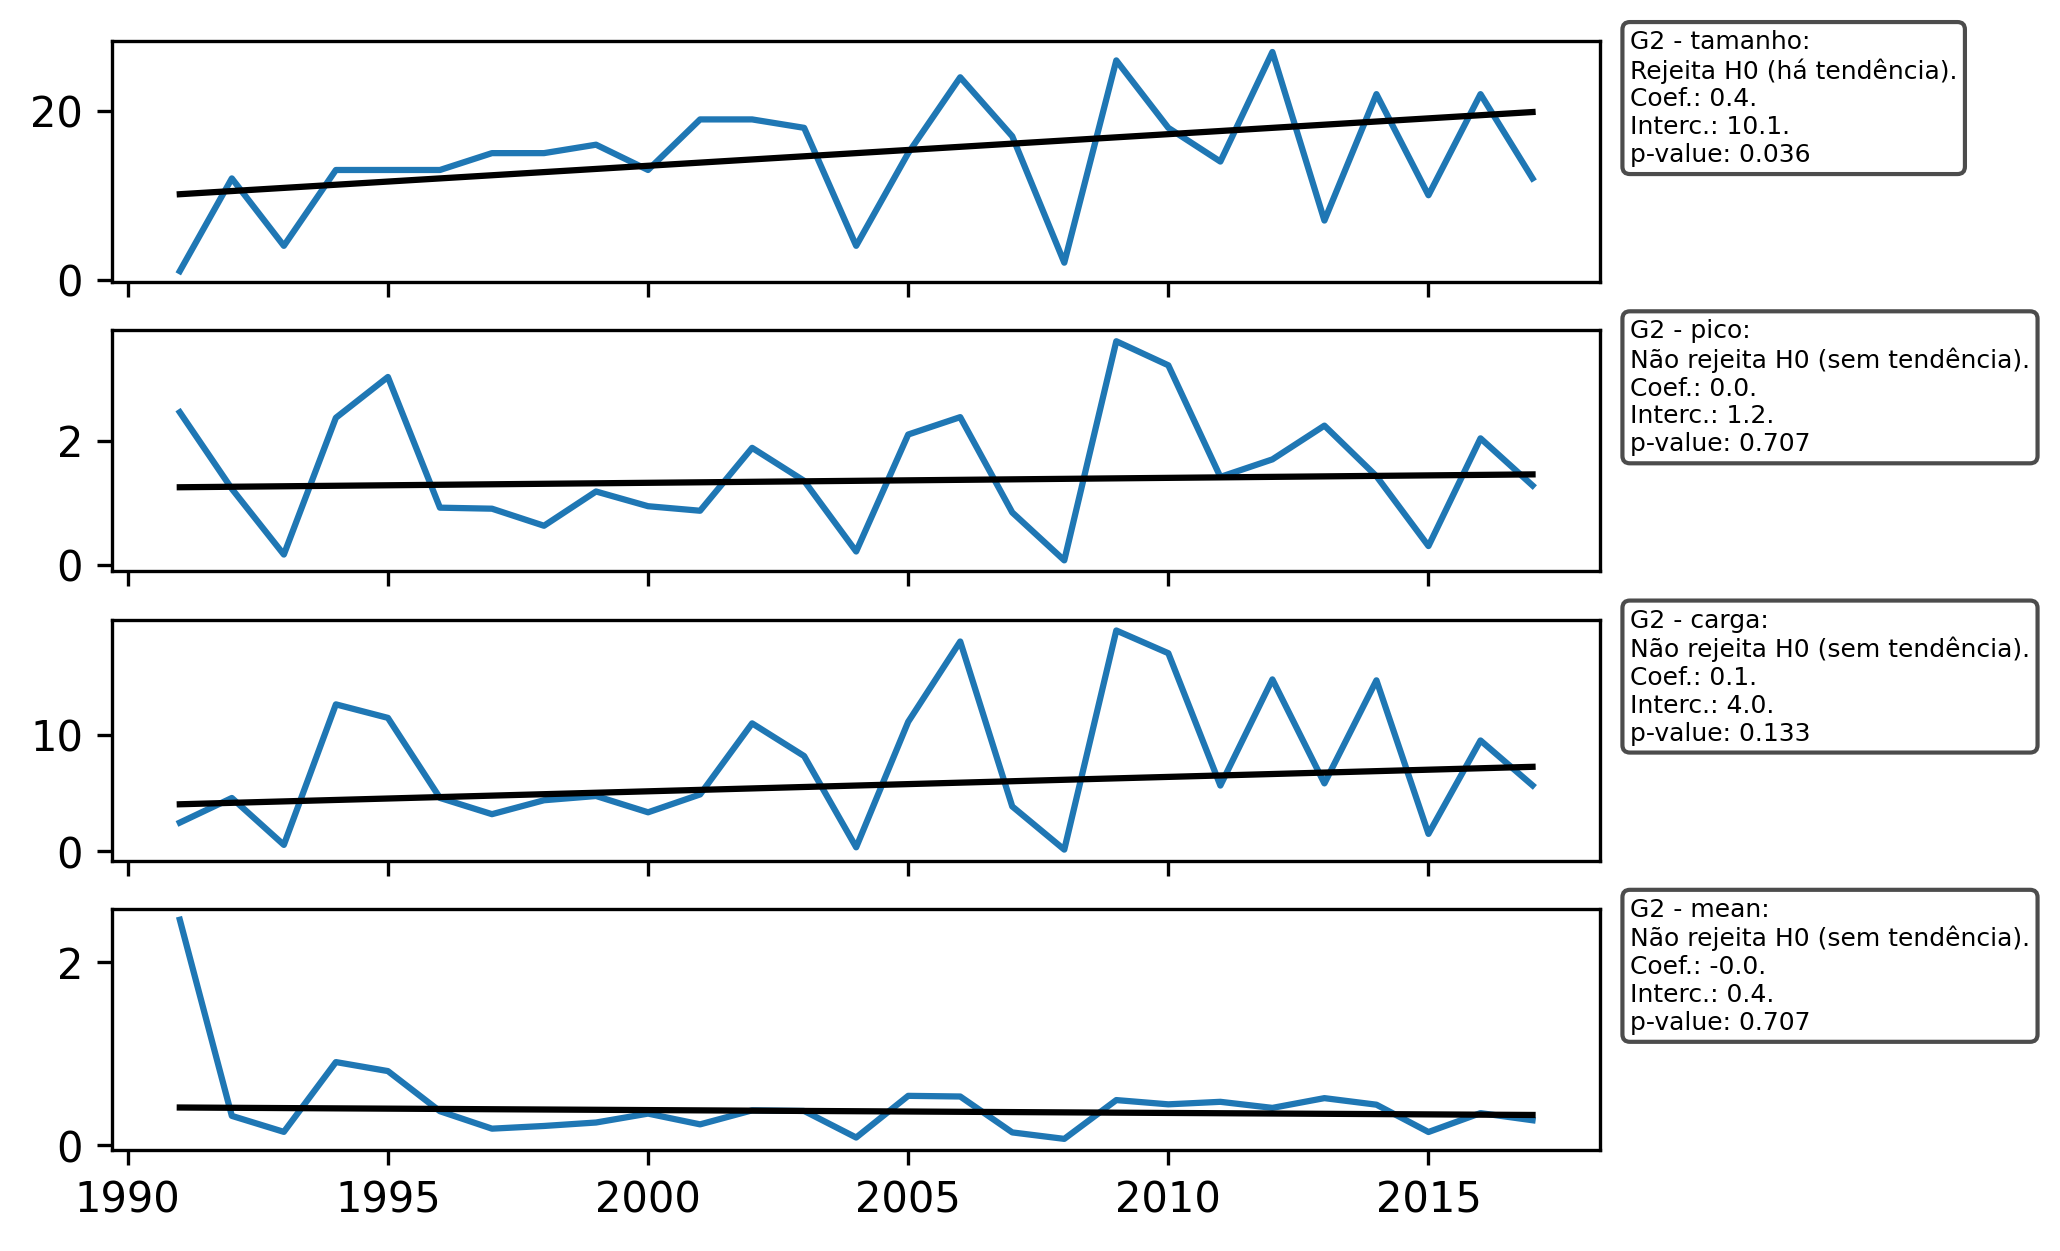

In [7]:
group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}


gstr = 'G2'

df_ehf, df_hws = extract(df_tmean, grupo=gstr)
tamanho = df_hws.groupby(df_hws.index.year)['tamanho'].sum()
pico = df_hws.groupby(df_hws.index.year)['pico'].max()
carga = df_hws.groupby(df_hws.index.year)['carga'].sum()
mean = df_hws.groupby(df_hws.index.year)['mean'].mean()

fig, ax = plt.subplots(4,1, dpi=300, sharex=True)

msgs = list()

tamanho.plot(ax=ax[0])
resultado, msg = test_mann_kendall(tamanho, f'{gstr} - tamanho')
trend_line = np.arange(len(tamanho)) * resultado.slope + resultado.intercept
ax[0].plot(tamanho.index, trend_line, color='black')

msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

msgs = list()

pico.plot(ax=ax[1])
resultado, msg = test_mann_kendall(pico, f'{gstr} - pico')
trend_line = np.arange(len(pico)) * resultado.slope + resultado.intercept
ax[1].plot(pico.index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

msgs = list()
carga.plot(ax=ax[2])
resultado, msg = test_mann_kendall(carga, f'{gstr} - carga')
trend_line = np.arange(len(carga)) * resultado.slope + resultado.intercept
ax[2].plot(carga.index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

msgs = list()
mean.plot(ax=ax[3])
resultado, msg = test_mann_kendall(mean, f'{gstr} - mean')
trend_line = np.arange(len(mean)) * resultado.slope + resultado.intercept
ax[3].plot(mean.index, trend_line, color='black')


msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

plt.show()

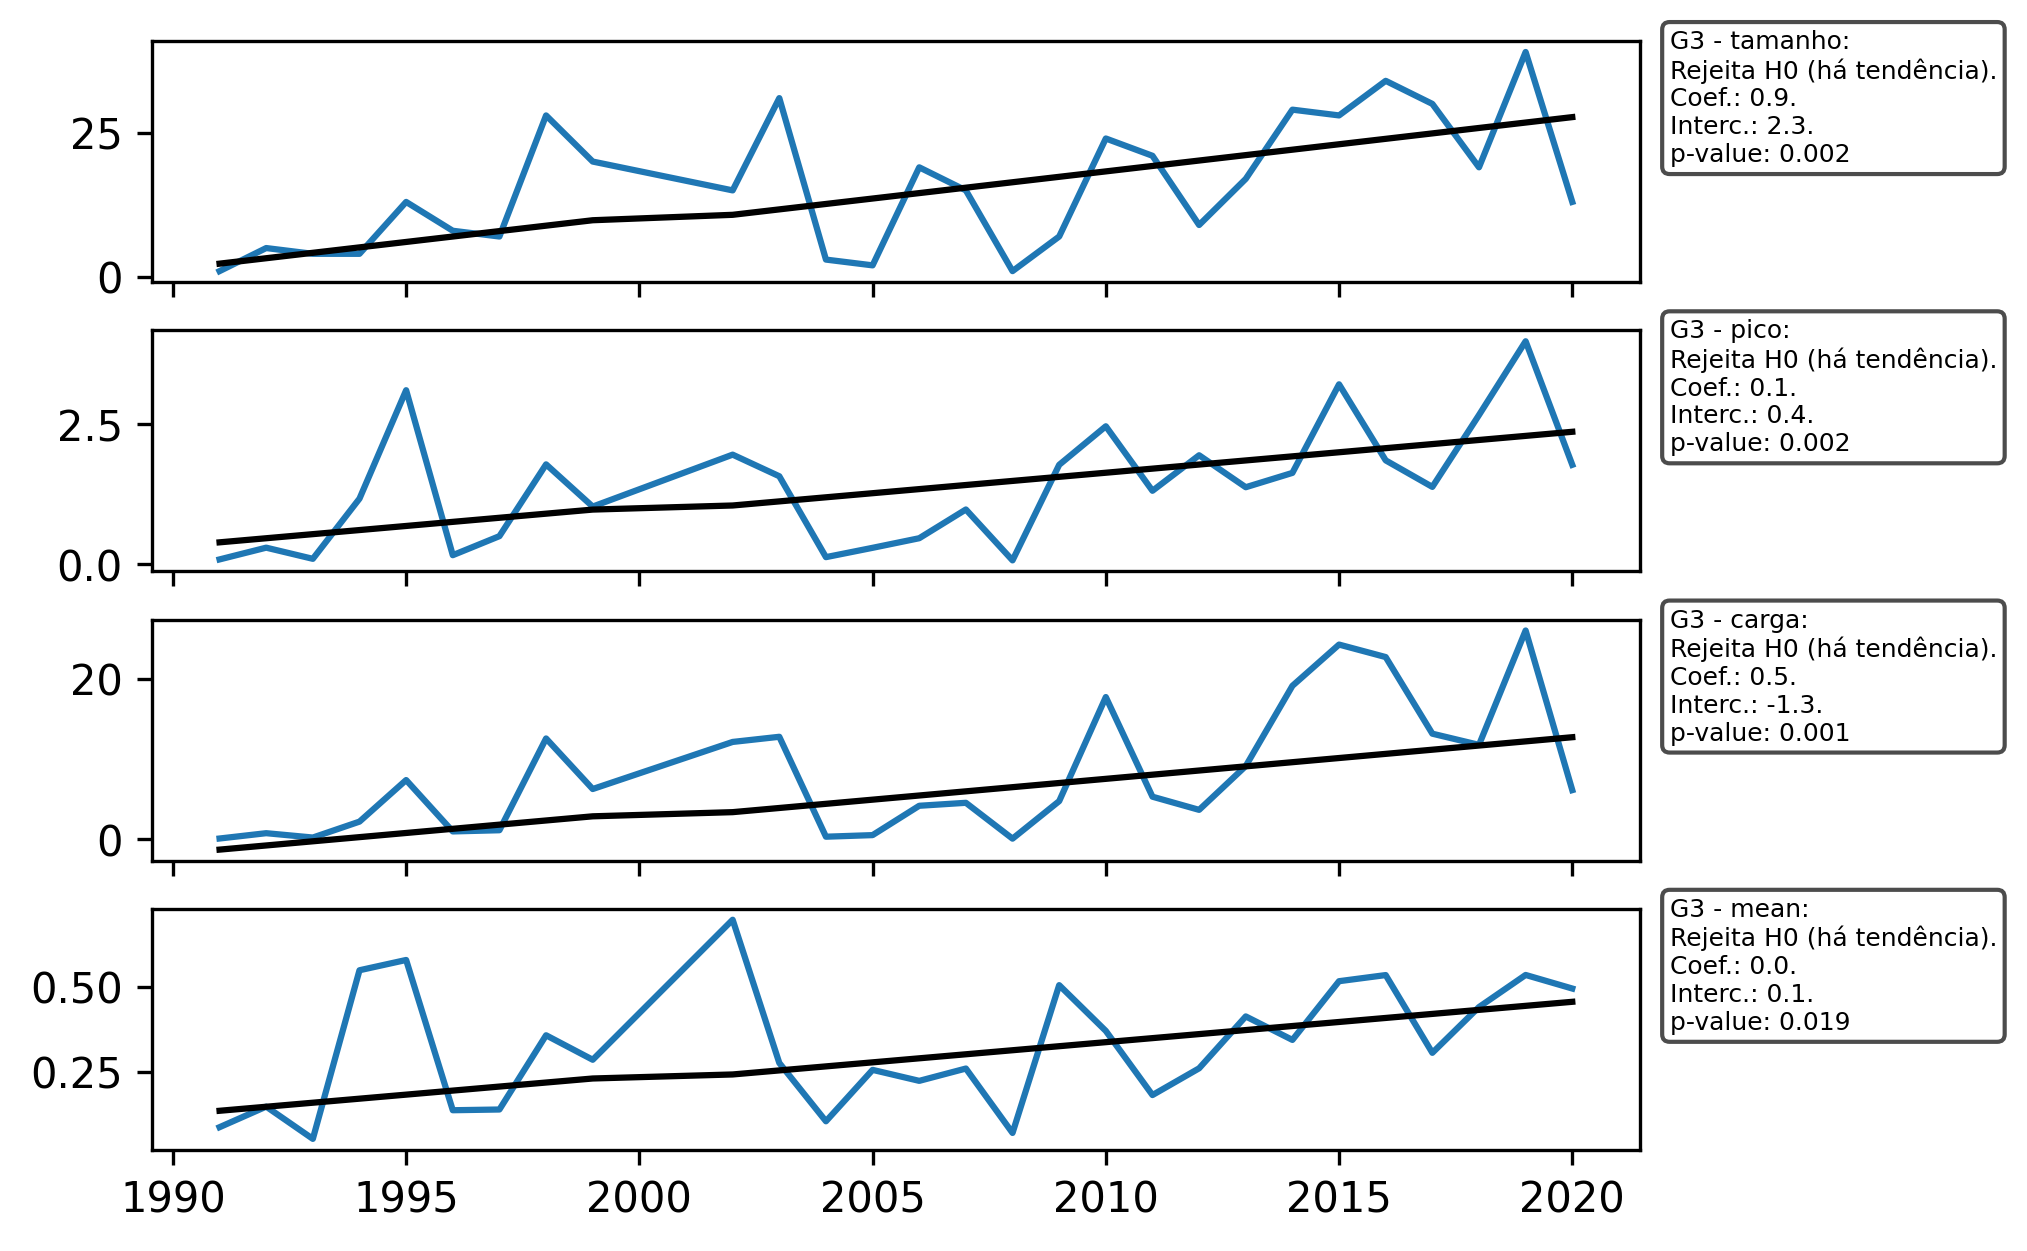

In [8]:

group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}

gstr = 'G3'

df_ehf, df_hws = extract(df_tmean, grupo=gstr)
tamanho = df_hws.groupby(df_hws.index.year)['tamanho'].sum()
pico = df_hws.groupby(df_hws.index.year)['pico'].max()
carga = df_hws.groupby(df_hws.index.year)['carga'].sum()
mean = df_hws.groupby(df_hws.index.year)['mean'].mean()

fig, ax = plt.subplots(4,1, dpi=300, sharex=True)

msgs = list()

tamanho.plot(ax=ax[0])
resultado, msg = test_mann_kendall(tamanho, f'{gstr} - tamanho')
trend_line = np.arange(len(tamanho)) * resultado.slope + resultado.intercept
ax[0].plot(tamanho.index, trend_line, color='black')

msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

msgs = list()

pico.plot(ax=ax[1])
resultado, msg = test_mann_kendall(pico, f'{gstr} - pico')
trend_line = np.arange(len(pico)) * resultado.slope + resultado.intercept
ax[1].plot(pico.index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

msgs = list()
carga.plot(ax=ax[2])
resultado, msg = test_mann_kendall(carga, f'{gstr} - carga')
trend_line = np.arange(len(carga)) * resultado.slope + resultado.intercept
ax[2].plot(carga.index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

msgs = list()
mean.plot(ax=ax[3])
resultado, msg = test_mann_kendall(mean, f'{gstr} - mean')
trend_line = np.arange(len(mean)) * resultado.slope + resultado.intercept
ax[3].plot(mean.index, trend_line, color='black')


msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

plt.show()

In [11]:
G1 = ehf(df_tmean['G1'], 0.95)
G2 = ehf(df_tmean['G2'], 0.95)
G3 = ehf(df_tmean['G3'], 0.95)

In [12]:
def pico(df):
    return df.resample('YE')['severity'].max()

def carga(df):
    return df.resample('YE')['severity'].sum()

def tamanho(df):
    return df.resample('YE')['severity'].count()

def media(df):
    return carga(df) / tamanho(df)

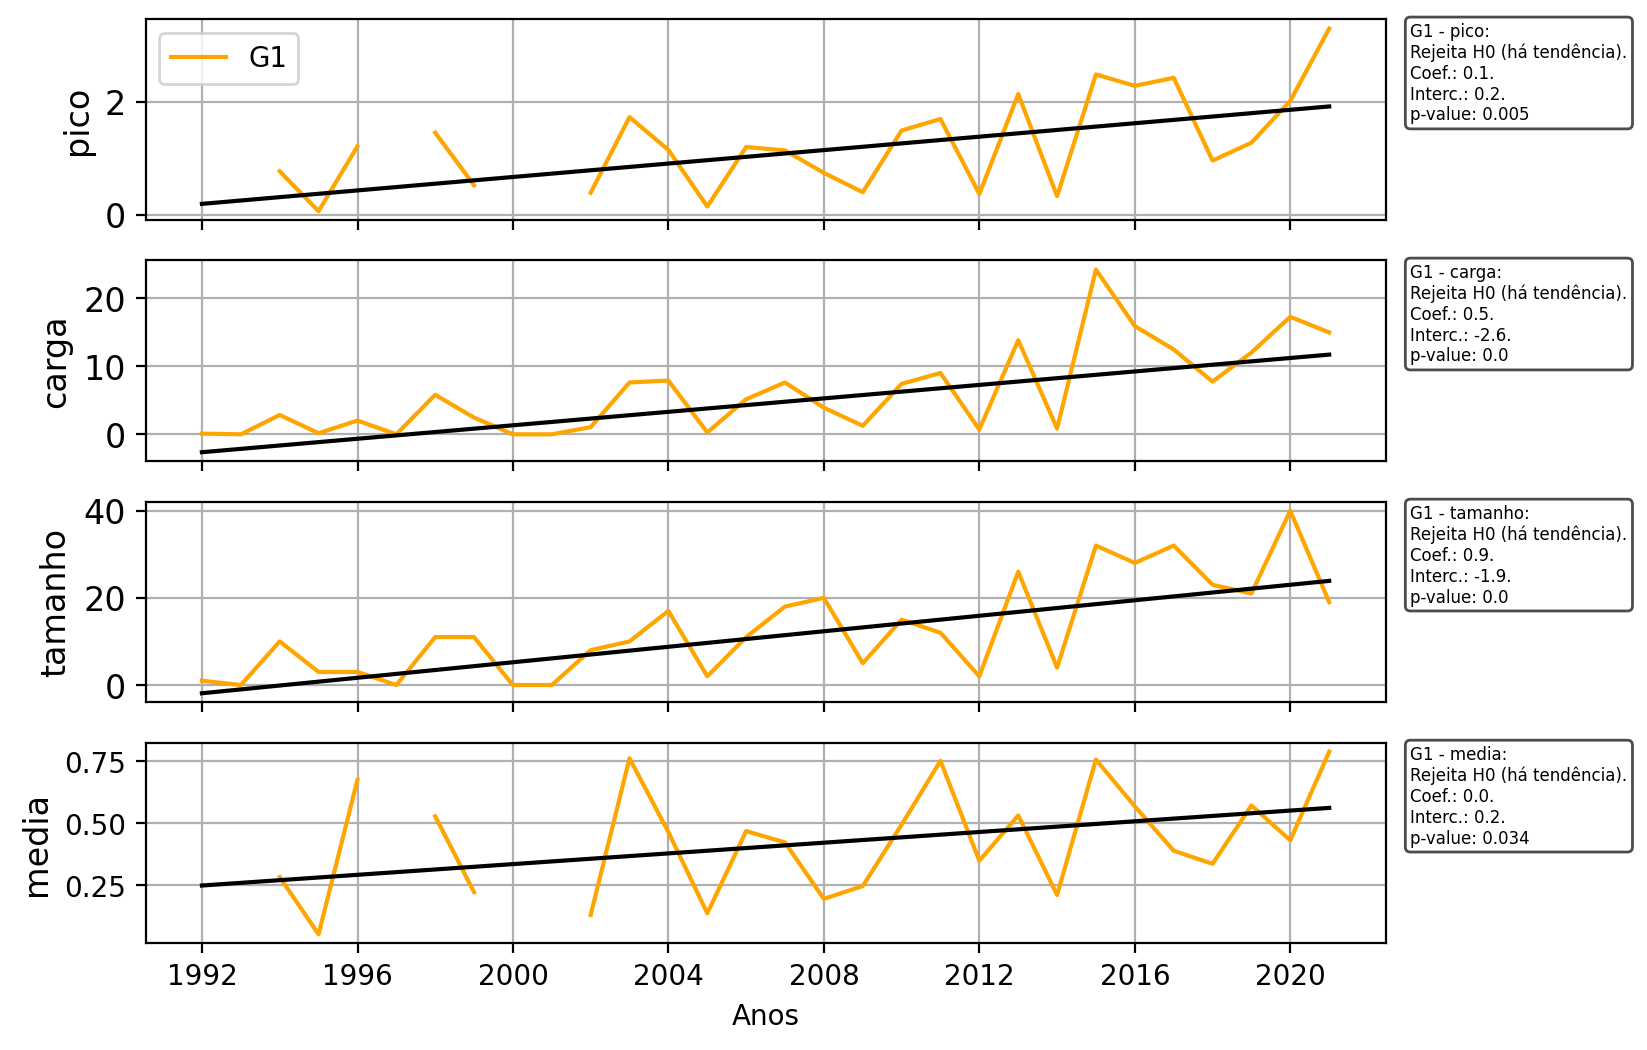

In [13]:
group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}

g, gstr = G1, 'G1'

fig, ax = plt.subplots(4,1, figsize=(8, 6), dpi=200, sharex=True)

msgs = list()
ax[0].plot(pico(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(pico(g), f'{gstr} - pico')
trend_line = np.arange(len(pico(g))) * resultado.slope + resultado.intercept
ax[0].plot(pico(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

ax[0].set_ylabel('pico', fontsize=12)
#ax[0].set_ylim(0,140)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()
ax[0].legend()


msgs = list()
ax[1].plot(carga(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(carga(g), f'{gstr} - carga')
trend_line = np.arange(len(carga(g))) * resultado.slope + resultado.intercept
ax[1].plot(carga(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3 

ax[1].set_ylabel('carga', fontsize=12)
#ax[1].set_ylim(0,15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

msgs = list()
ax[2].plot(tamanho(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(tamanho(g), f'{gstr} - tamanho')
trend_line = np.arange(len(tamanho(g))) * resultado.slope + resultado.intercept
ax[2].plot(tamanho(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  
    
ax[2].set_ylabel('tamanho', fontsize=12)
#ax[2].set_ylim(0,50)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].grid()


msgs = list()
ax[3].plot(media(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(media(g), f'{gstr} - media')
trend_line = np.arange(len(media(g))) * resultado.slope + resultado.intercept
ax[3].plot(media(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3 

ax[3].set_ylabel('media', fontsize=12)
ax[3].set_xlabel('Anos')
#ax[3].set_ylim(0,5)
ax[3].grid()

plt.show()

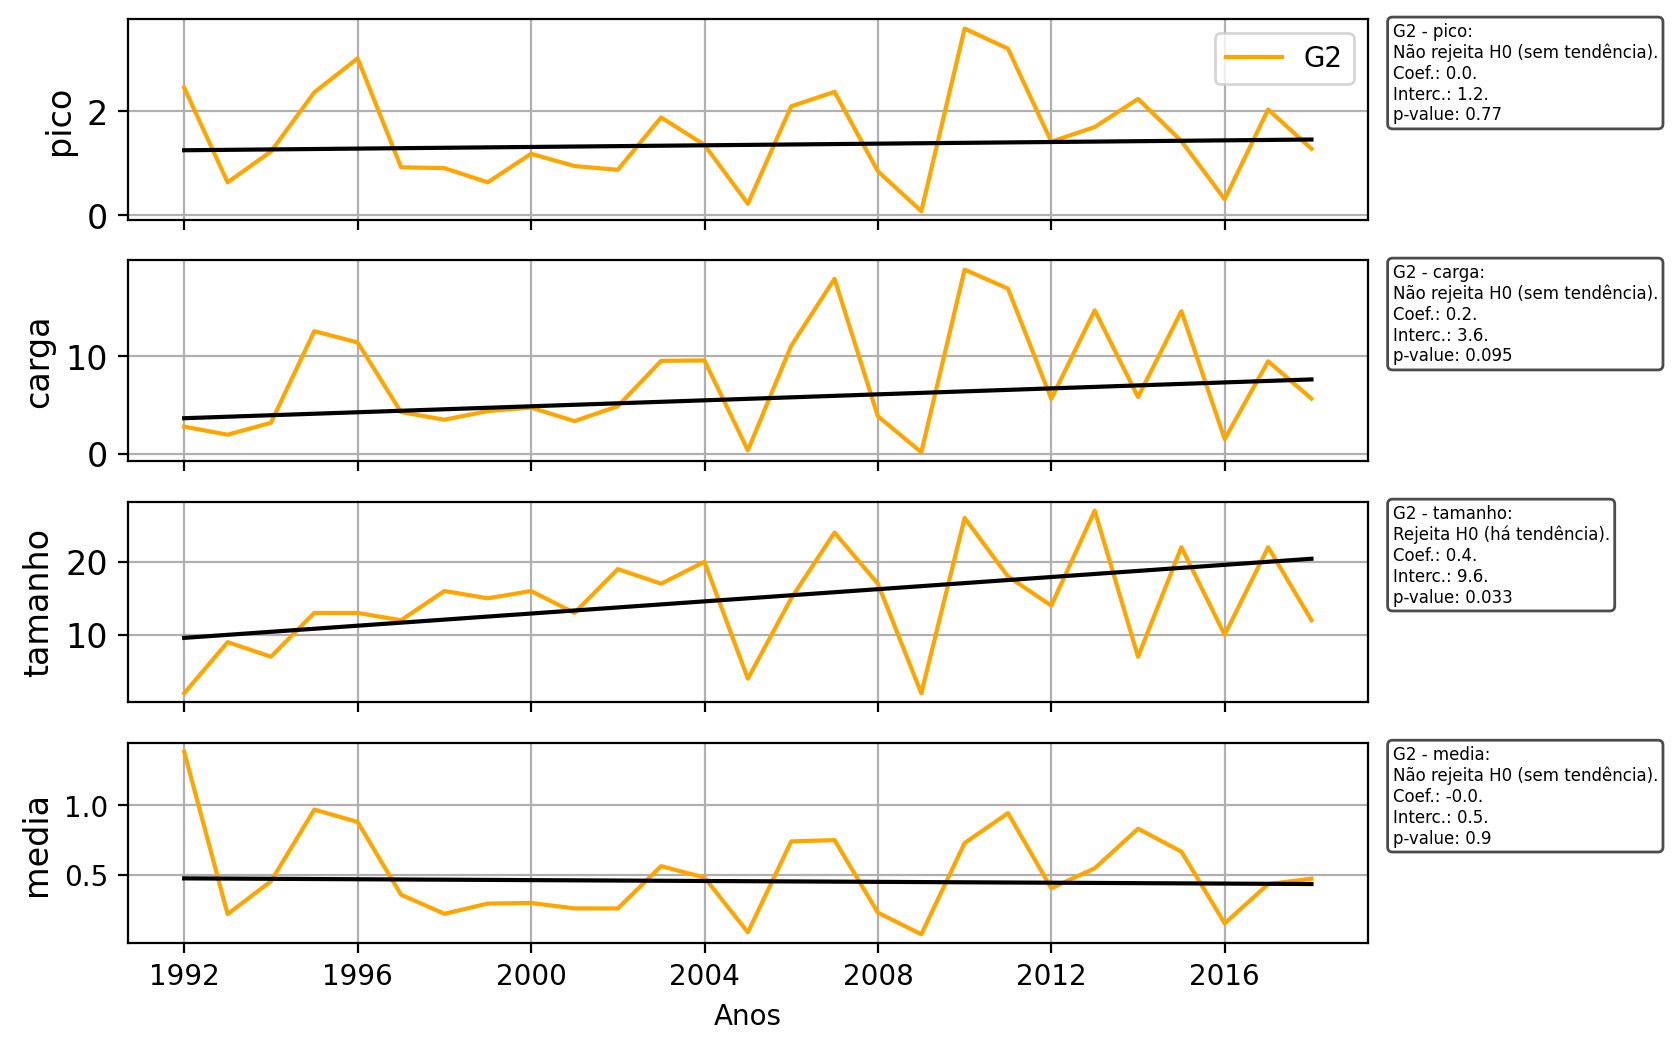

In [14]:
group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}

g, gstr = G2, 'G2'

fig, ax = plt.subplots(4,1, figsize=(8, 6), dpi=200, sharex=True)

msgs = list()
ax[0].plot(pico(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(pico(g), f'{gstr} - pico')
trend_line = np.arange(len(pico(g))) * resultado.slope + resultado.intercept
ax[0].plot(pico(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

ax[0].set_ylabel('pico', fontsize=12)
#ax[0].set_ylim(0,140)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()
ax[0].legend()


msgs = list()
ax[1].plot(carga(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(carga(g), f'{gstr} - carga')
trend_line = np.arange(len(carga(g))) * resultado.slope + resultado.intercept
ax[1].plot(carga(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3 

ax[1].set_ylabel('carga', fontsize=12)
#ax[1].set_ylim(0,15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

msgs = list()
ax[2].plot(tamanho(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(tamanho(g), f'{gstr} - tamanho')
trend_line = np.arange(len(tamanho(g))) * resultado.slope + resultado.intercept
ax[2].plot(tamanho(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  
    
ax[2].set_ylabel('tamanho', fontsize=12)
#ax[2].set_ylim(0,50)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].grid()


msgs = list()
ax[3].plot(media(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(media(g), f'{gstr} - media')
trend_line = np.arange(len(media(g))) * resultado.slope + resultado.intercept
ax[3].plot(media(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3 

ax[3].set_ylabel('media', fontsize=12)
ax[3].set_xlabel('Anos')
#ax[3].set_ylim(0,5)
ax[3].grid()

plt.show()

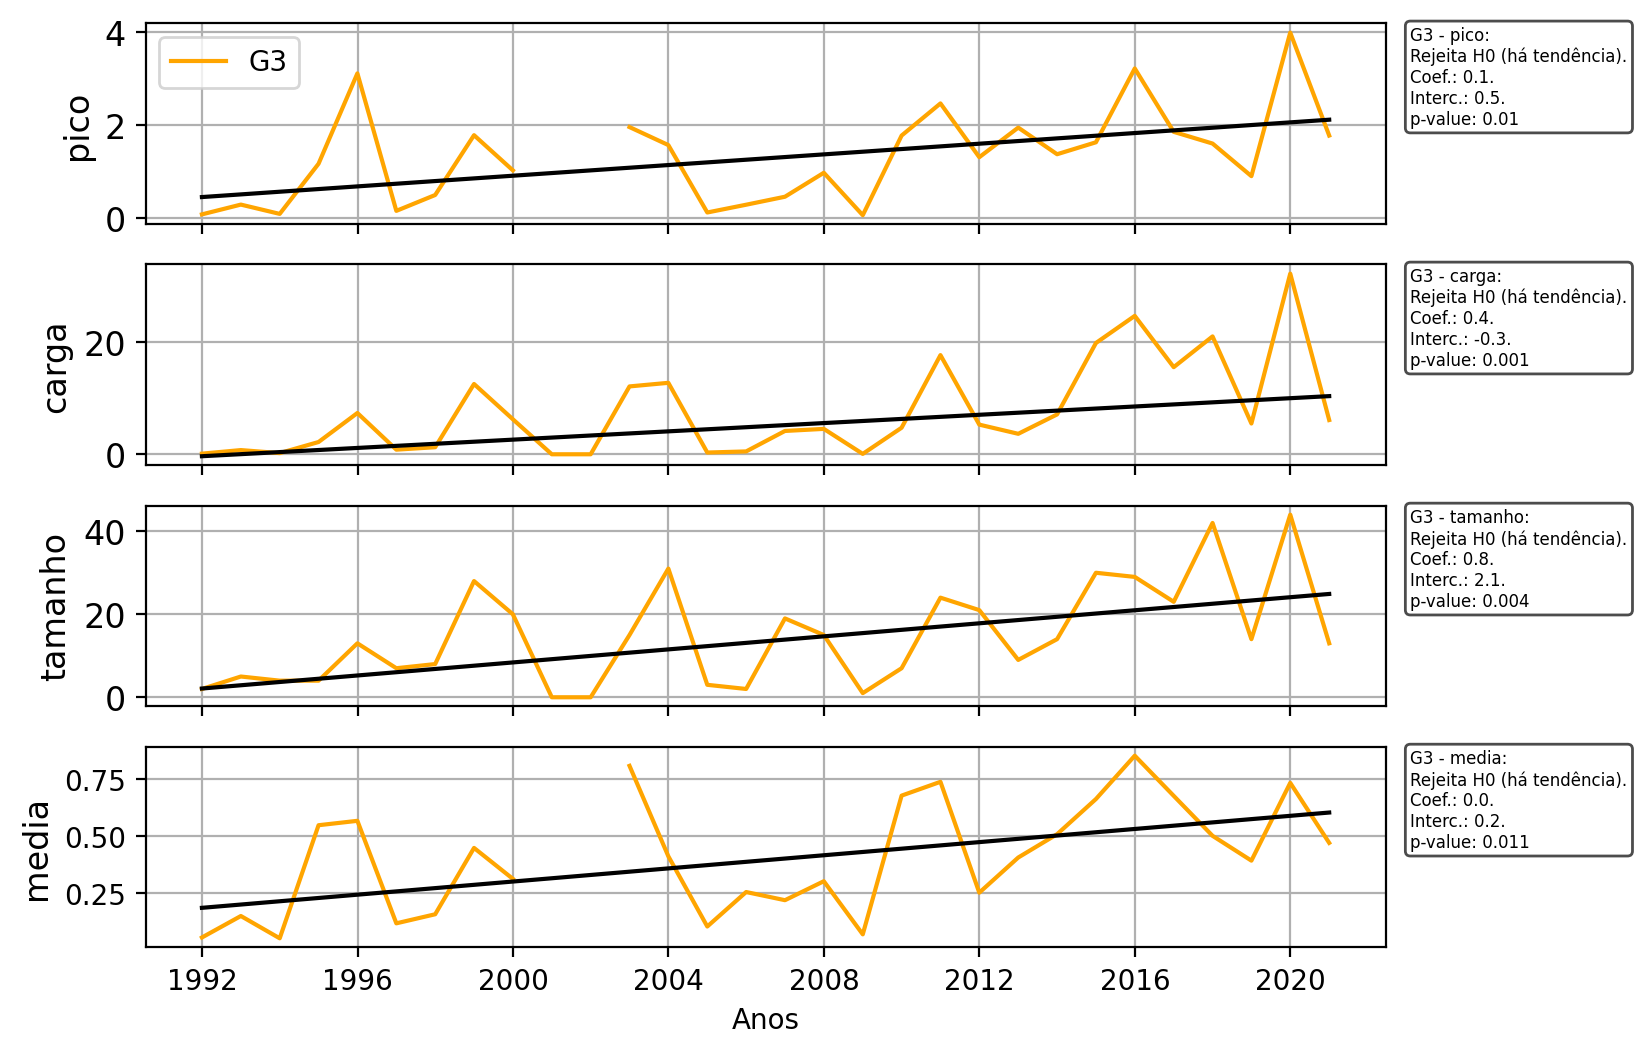

In [15]:
group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}

g, gstr = G3, 'G3'

fig, ax = plt.subplots(4,1, figsize=(8, 6), dpi=200, sharex=True)

msgs = list()
ax[0].plot(pico(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(pico(g), f'{gstr} - pico')
trend_line = np.arange(len(pico(g))) * resultado.slope + resultado.intercept
ax[0].plot(pico(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3

ax[0].set_ylabel('pico', fontsize=12)
#ax[0].set_ylim(0,140)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()
ax[0].legend()


msgs = list()
ax[1].plot(carga(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(carga(g), f'{gstr} - carga')
trend_line = np.arange(len(carga(g))) * resultado.slope + resultado.intercept
ax[1].plot(carga(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3 

ax[1].set_ylabel('carga', fontsize=12)
#ax[1].set_ylim(0,15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

msgs = list()
ax[2].plot(tamanho(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(tamanho(g), f'{gstr} - tamanho')
trend_line = np.arange(len(tamanho(g))) * resultado.slope + resultado.intercept
ax[2].plot(tamanho(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  
    
ax[2].set_ylabel('tamanho', fontsize=12)
#ax[2].set_ylim(0,50)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].grid()


msgs = list()
ax[3].plot(media(g), label=gstr, color='orange')
resultado, msg = test_mann_kendall(media(g), f'{gstr} - media')
trend_line = np.arange(len(media(g))) * resultado.slope + resultado.intercept
ax[3].plot(media(g).index, trend_line, color='black')
msgs.append(msg)


x, y = 1.02, 0.5
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3 

ax[3].set_ylabel('media', fontsize=12)
ax[3].set_xlabel('Anos')
#ax[3].set_ylim(0,5)
ax[3].grid()

plt.show()